In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import sys,os
from core.data import pretraining_pipeline

%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# ASTROMER input format

In [13]:
dataset_name = 'macho'
dataset = pretraining_pipeline('./data/records/{}/train/'.format(dataset_name, dataset_name), 
                               256, window_size=20, 
                               msk_frac=0.5, rnd_frac=0.2, same_frac=0.2,
                               sampling=True, shuffle=False)
objects = pd.read_csv('./data/records/{}/objects.csv'.format(dataset_name, dataset_name))
objects

,label,size
0,NonVar,1529386


In [6]:
# fig.savefig('presentation/figures/alcock_vs_macho.pdf', format='pdf', bbox_inches='tight')

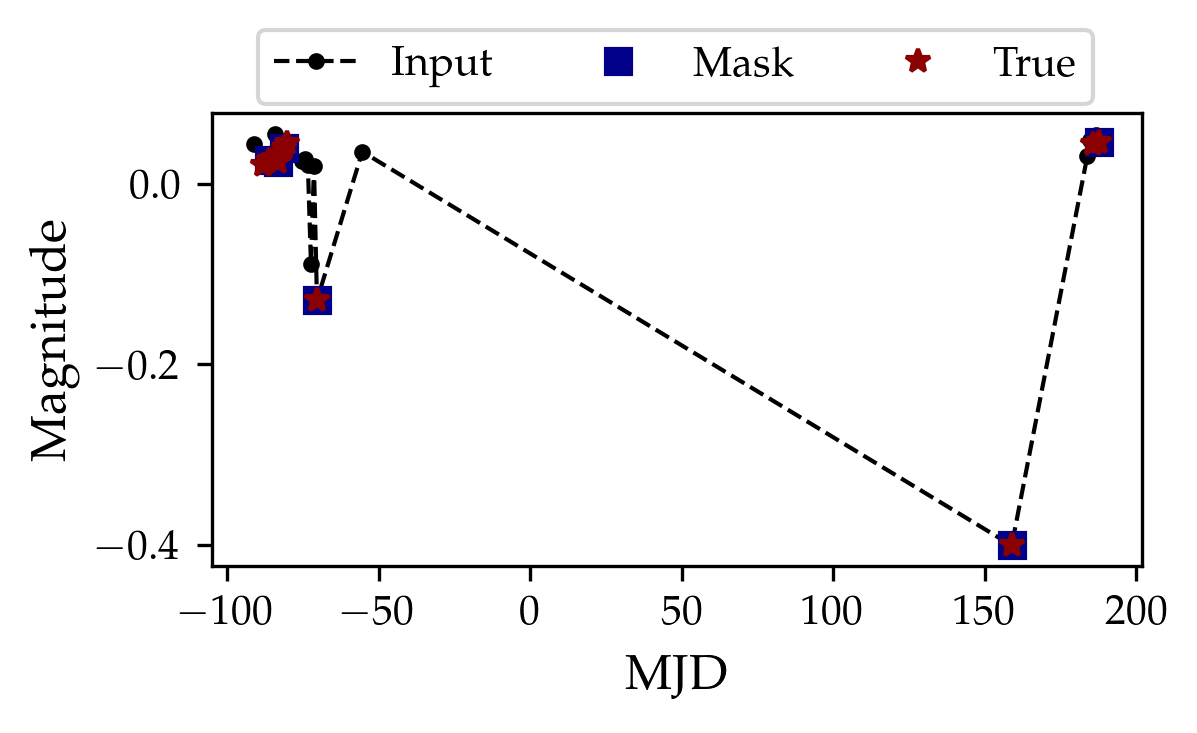

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(4,2), sharex=True, sharey=True, 
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, dpi=300)
lim = 20
start = 0
oid = 'F_1.4175.3433'.encode("utf-8")
for i, (batch, y) in enumerate(dataset):

    x_input  = batch['input'][-1][start:start+lim]
    x_output = y['target'][-1][start:start+lim]
    t_sample = batch['times'][-1][start:start+lim]

    mask_in  = tf.squeeze(batch['mask_in'][-1][start:start+lim])
    mask_out = tf.squeeze(y['mask_out'][-1][start:start+lim])


    times_masked = tf.boolean_mask(t_sample, mask_in)
    serie_masked = tf.boolean_mask(x_input, mask_in)


    times_masked_out = tf.boolean_mask(t_sample, mask_out)
    serie_masked_out = tf.boolean_mask(x_input, mask_out)

    axes.plot(t_sample, x_output, color='k', linestyle='--', marker='.', label='Input', linewidth=1)
    axes.plot(times_masked, serie_masked, marker='s', linestyle='', color='darkblue', label='Mask', linewidth=1)
    axes.plot(times_masked_out, serie_masked_out, color='darkred', linestyle='', marker='*', label='True', linewidth=1)

    axes.set_xlabel('MJD', fontsize=12)
    axes.set_ylabel('Magnitude', fontsize=12)    
    axes.legend(ncol=3, bbox_to_anchor=(0.97, 1.23))
    break
# fig.savefig('presentation/figures/input.png', transparent=True)
# fig.savefig('presentation/figures/input.pdf', format='pdf', bbox_inches='tight')

In [8]:
# fig.savefig('./presentation/figures/input.pdf', format='pdf', bbox_inches='tight')

# Classification input 

In [9]:
cd /home

/home


In [10]:
import tensorflow as tf 
import os, sys
import matplotlib.pyplot as plt
from core.data import pretraining_pipeline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
df_labels = pd.read_csv('./data/records/alcock/fold_0/alcock/objects.csv')
class_names = df_labels['label'].values
n_classes = len(class_names)
df_labels

,label,size
0,Cep_0,1082
1,Cep_1,583
2,EC,6724
3,LPV,2946
4,RRab,7297
5,RRc,1662


In [12]:
dataset = pretraining_pipeline('./data/records/alcock/fold_0/alcock/train/',
                                batch_size=128,
                                shuffle=True,
                                cache=True,
                                window_size=200,
                                sampling=False,
                                msk_frac=0.,
                                rnd_frac=0.,
                                same_frac=0.,
                                per_sample_mask=True,
                                num_cls=n_classes)

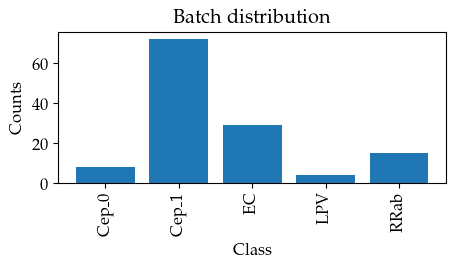

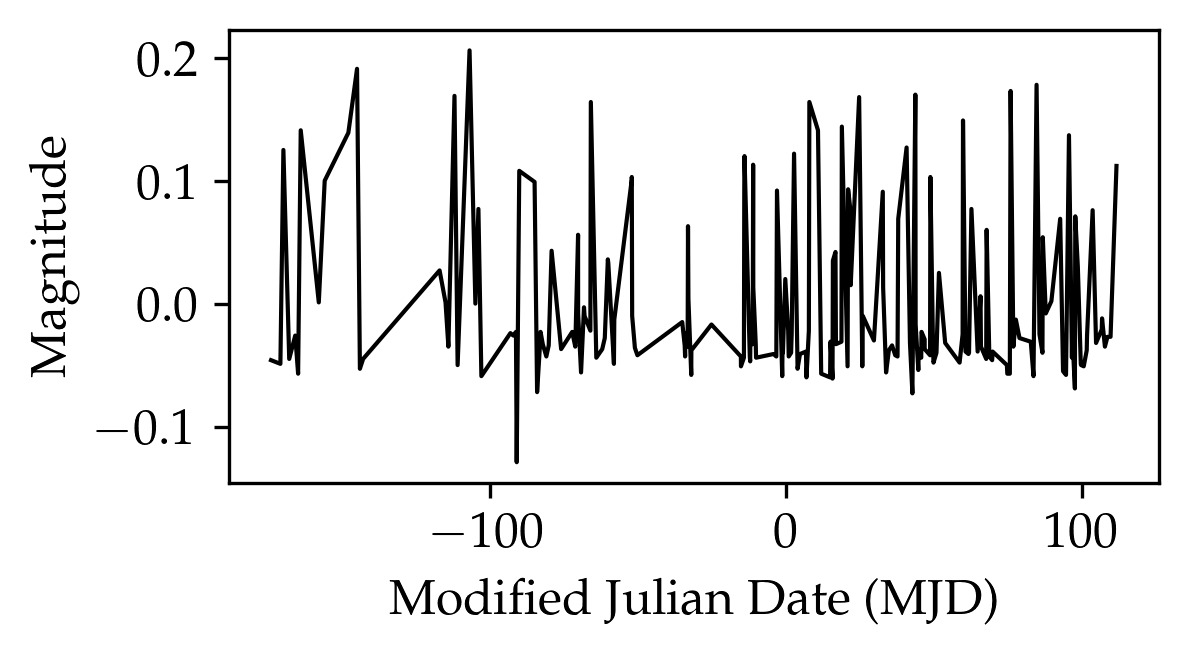

2022-09-08 20:15:59.110785: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [13]:
plt.rcParams.update({'font.size': 12})
for batch, y in dataset:
    y_label  = y[-1]
    x_input  = batch['input'][-1]
    t_sample = batch['times'][-1]
    
    mask_in  = tf.squeeze(batch['mask_in'][-1])

    times_masked = tf.boolean_mask(t_sample, mask_in)
    serie_masked = tf.boolean_mask(x_input, mask_in)
    
    # BATCH DISTRIBUTION
    plt.figure(figsize=(5,2), dpi=100)
    batch_labels = np.argmax(y.numpy(), 1)
    uniques, counts = np.unique(batch_labels, return_counts=True)
    x = range(len(uniques))
    plt.bar(x, counts)
    plt.xticks(x, class_names[:len(uniques)], rotation=90)
    plt.title('Batch distribution')
    plt.xlabel('Class')
    plt.ylabel('Counts')
    plt.show()
    
    # Lightcurve
    fig, axes = plt.subplots(1, 1, figsize=(4,2), sharex=True, sharey=True, 
                             gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, dpi=300)
    axes.plot(t_sample, x_input, color='k', linestyle='-', marker='', label='Input', linewidth=1)
#     axes.set_title('{}'.format(str(class_names[y_label])))
    axes.set_xlabel('Modified Julian Date (MJD)')
    axes.set_ylabel('Magnitude')   
#     fig.savefig('presentation/figures/raw_input.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    break

# Next Segment Prediction

In [25]:
dataset_name = 'macho'
dataset = pretraining_pipeline('./data/records/{}/train/'.format(dataset_name, dataset_name), 
                               256, window_size=200, 
                               msk_frac=0.5, rnd_frac=0.2, same_frac=0.2,
                               sampling=False, shuffle=False,
                               nsp_prob=1., nsp_frac=.5, nsp_test=True, moving_window=True)

[INFO] Using NSP


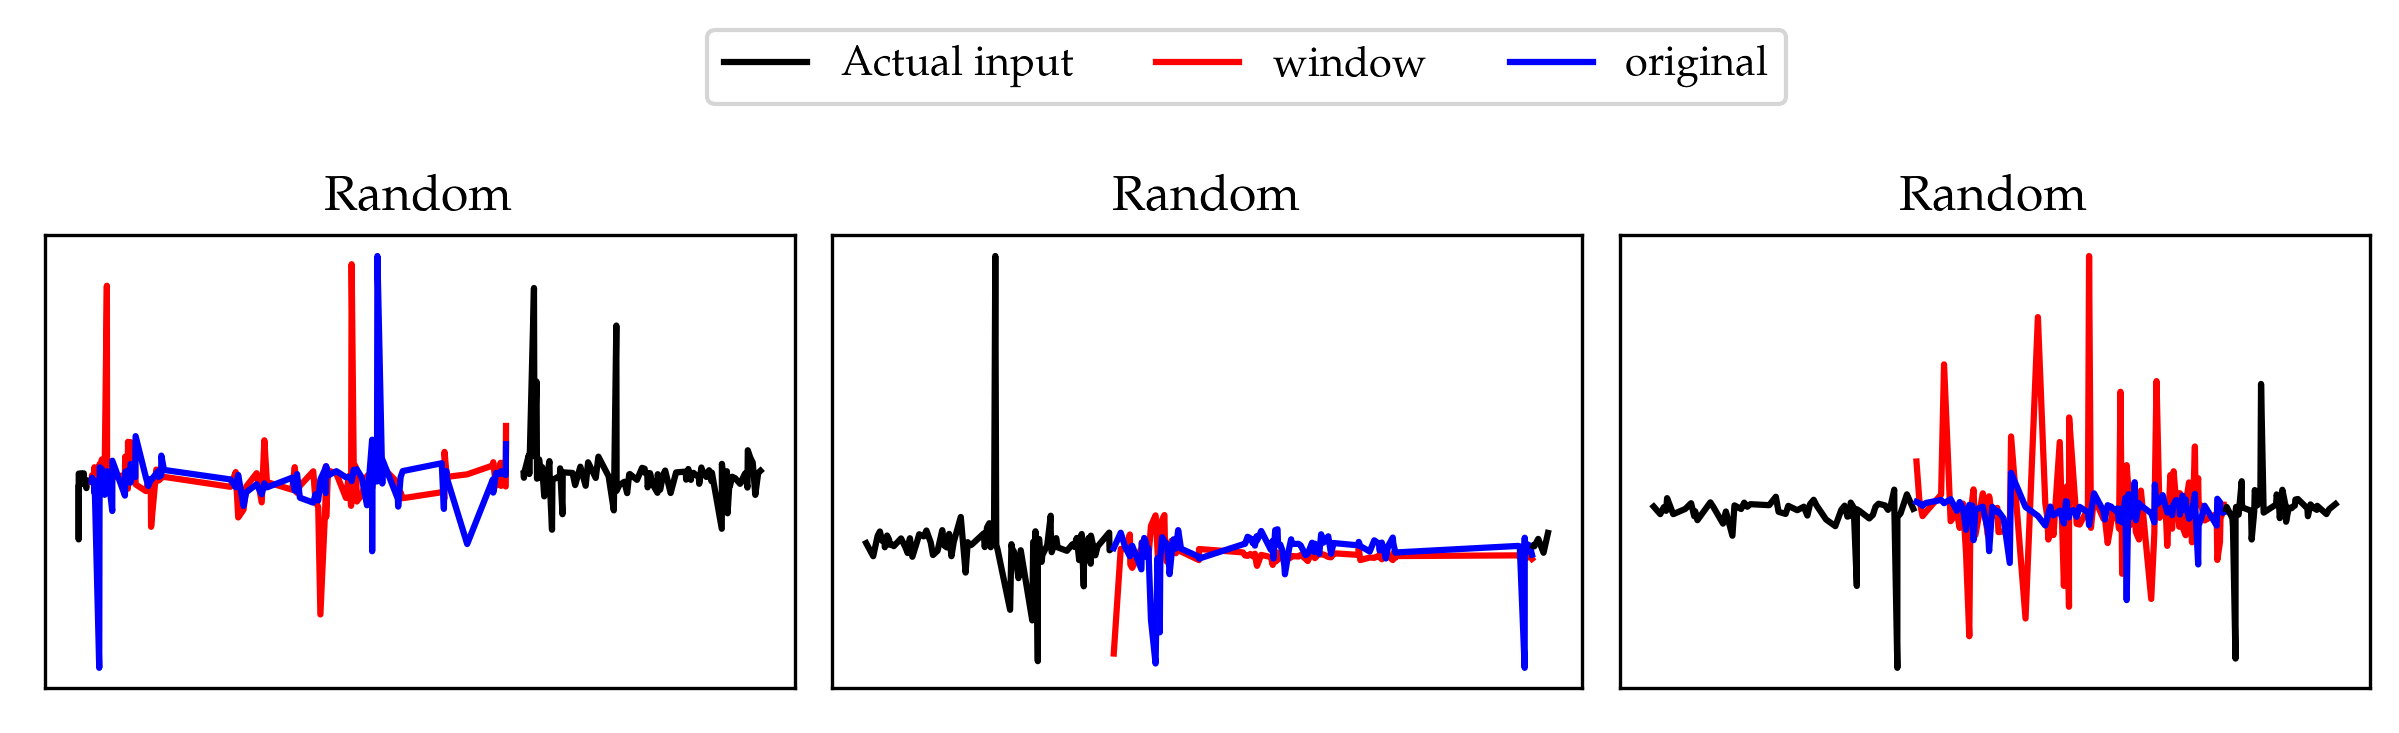

In [29]:
def get_segments(tensor, indices):
    seg_0 = tf.slice(tensor, [1],[indices[0][0]-1]) 
    seg_1 = tf.slice(tensor, [indices[0][0]+1],[indices[1][0]-indices[0][0]-1])
    seg_2 = tf.slice(tensor, [indices[1][0]+1],[-1])
    return seg_0, seg_1, seg_2


fig, axes = plt.subplots(1, 3, figsize=(10,2),
                         gridspec_kw={'hspace': 0.2, 'wspace': 0.05}, dpi=300)

for k, (ax, (x, y)) in enumerate(zip(axes.flatten(), dataset.unbatch())):
 
    inp_sample = y['target'][:, 0]
    indices = tf.where(inp_sample == -98)

    x_0, x_1, x_2 = get_segments(inp_sample, indices)
    t_0, t_1, t_2 = get_segments(x['times'][...,0], indices)
    o_0, o_1, o_2 = get_segments(x['original_input'][...,1], indices)

    ax.plot(t_0, x_0, color='k', label='Actual input')
    ax.plot(t_1, x_1, label='window', color='red')
    ax.plot(t_1, o_1, label='original', color='blue')
    ax.plot(t_2, x_2, color='k')
        
    if y['nsp_label'] == 0:
        ax.set_title('Random')
    else:
        ax.set_title('Actual')
    ax.set_xticks([])    
    
    ax.set_yticks([])
        
axes[1].legend(ncol=3, bbox_to_anchor=(1.3, 1.5))